# Maheen Shoukat
## 21i-2719 | BAI-5J

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
import zipfile
import os

In [3]:
import re
import spacy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
import tensorflow as tf
# Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizerFast, TFAutoModel

from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SpatialDropout1D, Conv1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import LAMB, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# Reading

In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [10]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11688161672720785217
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15724183552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13915236754797934671
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [12]:

with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip','r') as zip_ref:
    zip_ref.extractall("./sentiment-analysis-on-movie-reviews/")
with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip','r') as zip_ref:
    zip_ref.extractall("./sentiment-analysis-on-movie-reviews/")

In [13]:
pd.options.display.max_colwidth = 500

In [14]:
df = pd.read_table("/kaggle/working/sentiment-analysis-on-movie-reviews/train.tsv",sep='\t')
df = df[['Phrase','Sentiment']].copy()
df

,Phrase,Sentiment
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,A series of escapades demonstrating the adage that what is good for the goose,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


# Analysis on Data

## Class Count

In [15]:
print("0: " + str(len(df[df['Sentiment'] == 0])))
print("1: " + str(len(df[df['Sentiment'] == 1])))
print("2: " + str(len(df[df['Sentiment'] == 2])))
print("3: " + str(len(df[df['Sentiment'] == 3])))
print("4: " + str(len(df[df['Sentiment'] == 4])))

0: 7072
1: 27273
2: 79582
3: 32927
4: 9206


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


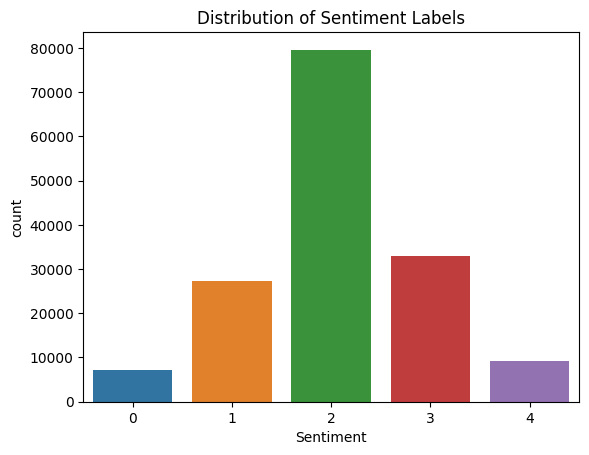

In [16]:
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

## Word cloud visulaization

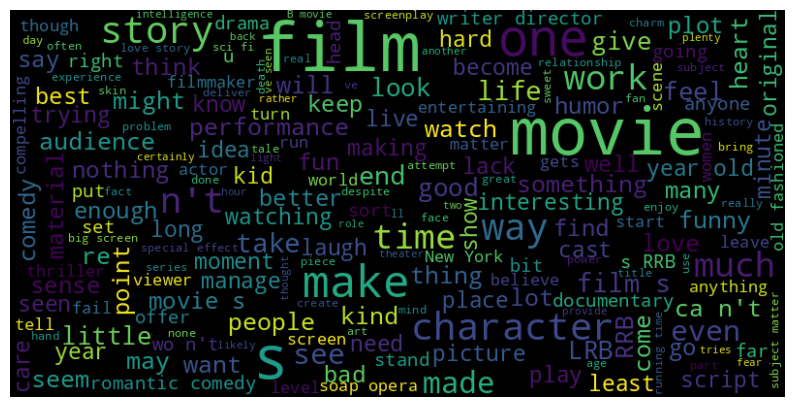

In [17]:
all_text = ' '.join(df['Phrase'])

wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=70).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Sentence Length 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


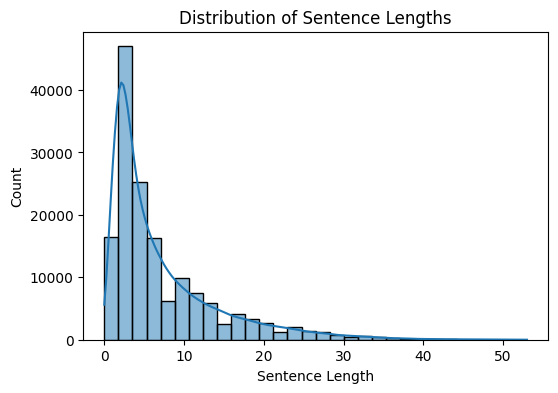

In [18]:
df['sentence_length'] = df['Phrase'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(6, 4))
sns.histplot(df['sentence_length'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.show()

In [19]:
df.head()

,Phrase,Sentiment,sentence_length
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,37
1,A series of escapades demonstrating the adage that what is good for the goose,2,14
2,A series,2,2
3,A,2,1
4,series,2,1


In [20]:
df= df.drop('sentence_length', axis=1)

<Axes: xlabel='Sentiment'>

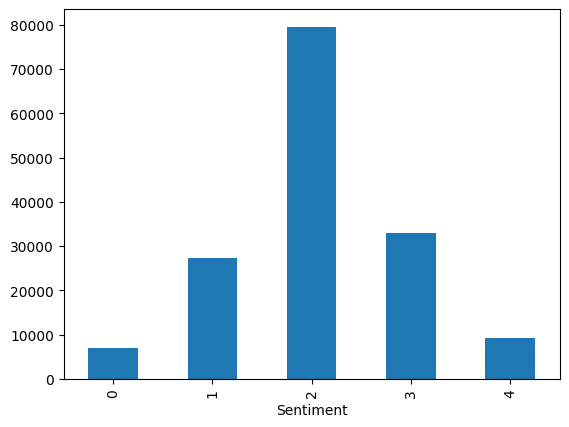

In [21]:
df.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

# Data Pre-processing

In [22]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

def remove_stopwords(text):
    text_tokens = text.split(" ")
    text_tokens_filtered= [word for word in text_tokens if not word in all_stopwords]
    return (" ").join(text_tokens_filtered)

def clean(text):
    # Removing stopwords decreased accuracies
#     text = remove_stopwords(text.lower())        
    text = re.sub(r'@|#', r'', text.lower())   
    text = re.sub(r'http.*', r'', text.lower()) 
    return ' '.join(re.findall(r'\w+', text.lower())) 

df['Phrase'] = df['Phrase'].apply(lambda x: clean(x))
df

,Phrase,Sentiment
0,a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story,1
1,a series of escapades demonstrating the adage that what is good for the goose,2
2,a series,2
3,a,2
4,series,2
...,...,...
156055,hearst s,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


# Data Splitting
## Train : 90% , Test: 10%
### Train further divided into -> (Train: 85%, Validation: 15%)

In [23]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.Sentiment.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=df.Sentiment)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df = df.dropna()

# Remove duplicates 
train_set = df[df['data_type'] == 'train'].drop_duplicates(ignore_index=True)
val_set = df[df['data_type'] == 'val'].drop_duplicates(ignore_index=True)
test_set = df[df['data_type'] == 'test'].drop_duplicates(ignore_index=True)

df = pd.concat([train_set, val_set, test_set], ignore_index=True)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Phrase,Sentiment,data_type
0,george w bush henry kissinger,2,train
1,age wise,2,train
2,the potential,2,train
3,practically any like themed film other than its oscar sweeping franchise predecessor,3,train
4,rarely has a film s title served such dire warning,0,val
...,...,...,...
149224,s not exactly worth,1,train
149225,welcome or accept the trials of henry kissinger as faithful portraiture,3,train
149226,rarely seem sure of where it should go,1,train
149227,the dialogue,2,train


# EDA

<Axes: xlabel='Sentiment'>

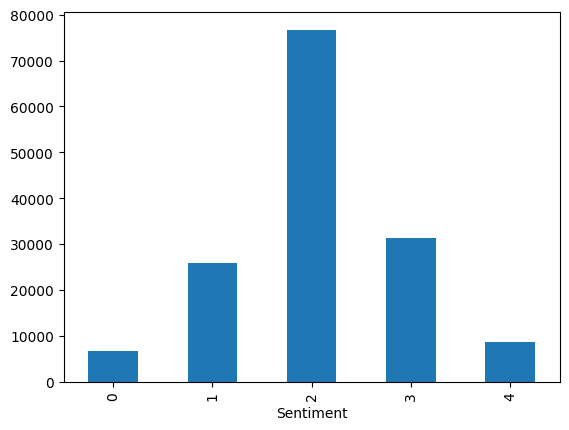

In [24]:
df.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

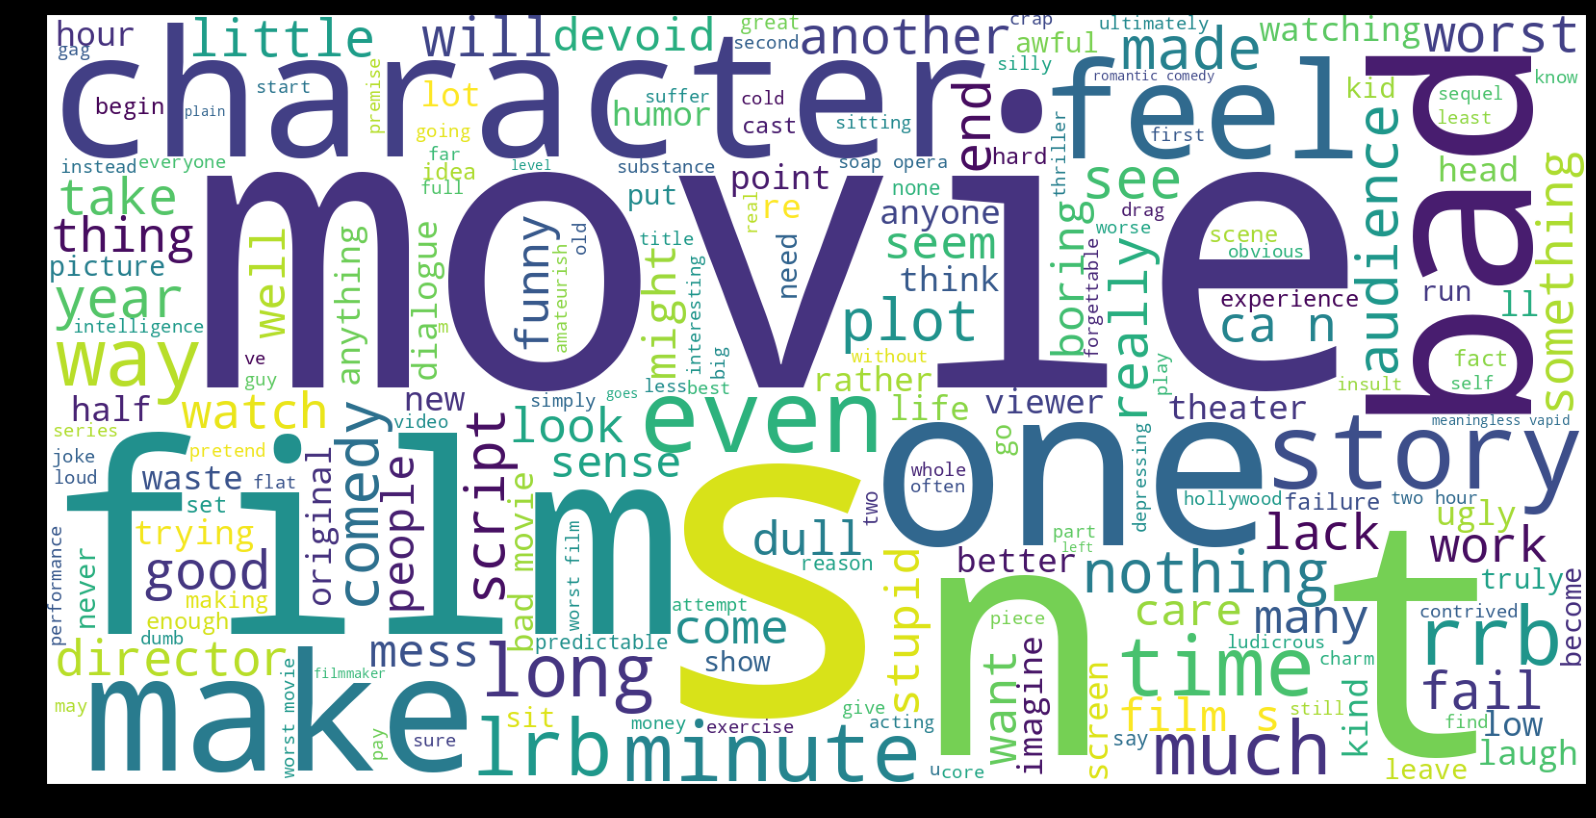

In [25]:
negative = df[df['Sentiment'] == 0]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(negative.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

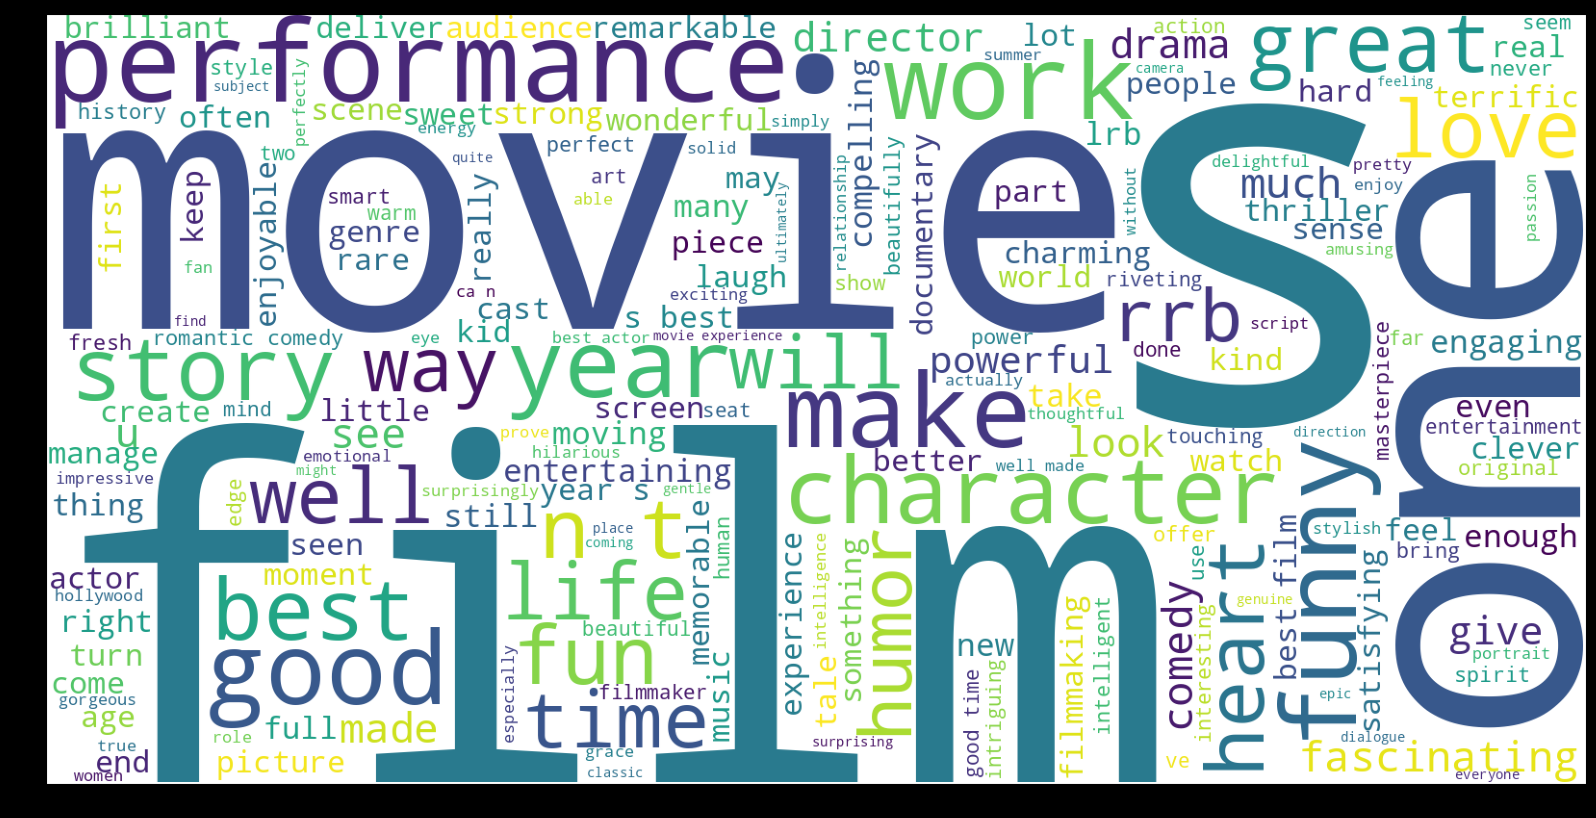

In [26]:
positive = df[df['Sentiment'] == 4]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(positive.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

# Traditional ML Algos

In [27]:
X_train = train_set.Phrase.values
Y_train = train_set.Sentiment.values
X_test = test_set.Phrase.values
Y_test = test_set.Sentiment.values
target_categories = ["0","1","2","3","4"]

## Naive Bayes Classifier

Naive Bayes Train Accuracy Score : 63% 
Naive Bayes Test Accuracy Score  : 59% 

              precision    recall  f1-score   support

           0       0.02      0.68      0.04        22
           1       0.24      0.51      0.32      1241
           2       0.91      0.60      0.73     11904
           3       0.38      0.54      0.44      2264
           4       0.04      0.62      0.08        65

    accuracy                           0.59     15496
   macro avg       0.32      0.59      0.32     15496
weighted avg       0.77      0.59      0.65     15496



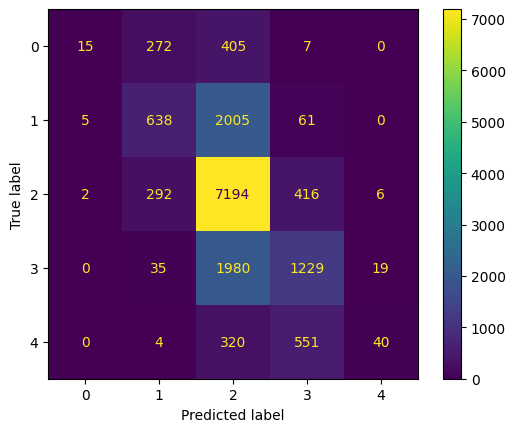

In [28]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
# print(X_test)

# Training the classifier with Naive Bayes
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, Y_train)
test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Support Vector Machine (SGD Classifier)

SVM Train Accuracy Score : 58% 
SVM Test Accuracy Score  : 56% 

              precision    recall  f1-score   support

           0       0.05      0.47      0.10        80
           1       0.11      0.47      0.17       611
           2       0.96      0.57      0.71     13315
           3       0.20      0.51      0.29      1305
           4       0.12      0.60      0.20       185

    accuracy                           0.56     15496
   macro avg       0.29      0.52      0.29     15496
weighted avg       0.84      0.56      0.65     15496



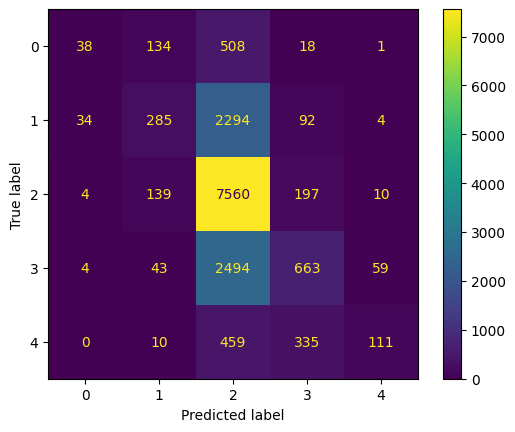

In [29]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])

sgd.fit(X_train, Y_train)
test_predict = sgd.predict(X_test)

train_accuracy = round(sgd.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("SVM Train Accuracy Score : {}% ".format(train_accuracy))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Decision Tree Classifier

Decision Tree Train Accuracy Score : 95% 
Decision Tree Test Accuracy Score  : 58% 

              precision    recall  f1-score   support

           0       0.31      0.34      0.33       636
           1       0.42      0.46      0.44      2451
           2       0.77      0.69      0.72      8818
           3       0.41      0.47      0.43      2850
           4       0.33      0.40      0.36       741

    accuracy                           0.58     15496
   macro avg       0.45      0.47      0.46     15496
weighted avg       0.60      0.58      0.59     15496



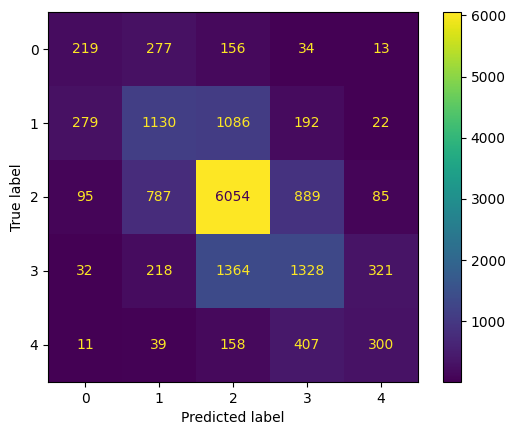

In [30]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)
test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## K-Nearest Neighbour Classifier

K-Nearest Neighbour Train Accuracy Score : 73% 
K-Nearest Neighbour Test Accuracy Score  : 62% 

              precision    recall  f1-score   support

           0       0.36      0.41      0.38       610
           1       0.47      0.50      0.48      2556
           2       0.81      0.68      0.74      9367
           3       0.43      0.56      0.49      2510
           4       0.27      0.55      0.36       453

    accuracy                           0.62     15496
   macro avg       0.47      0.54      0.49     15496
weighted avg       0.66      0.62      0.63     15496



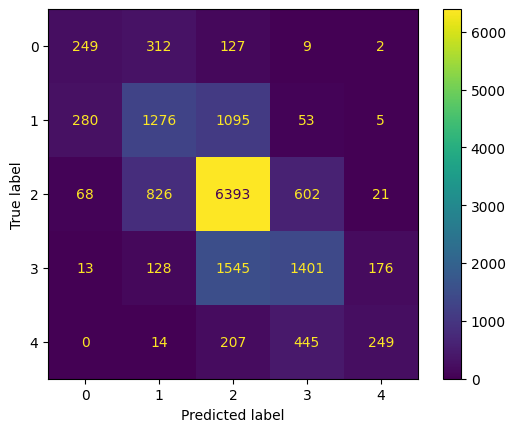

In [31]:
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
               ])

knn.fit(X_train, Y_train)
test_predict = knn.predict(X_test)

train_accuracy = round(knn.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Logistic Regression Classifier

Logistic Regression Train Accuracy Score : 66% 
Logistic Regression Test Accuracy Score  : 63% 

              precision    recall  f1-score   support

           0       0.13      0.60      0.21       149
           1       0.31      0.53      0.39      1588
           2       0.90      0.65      0.76     10915
           3       0.44      0.57      0.50      2546
           4       0.22      0.67      0.33       298

    accuracy                           0.63     15496
   macro avg       0.40      0.61      0.44     15496
weighted avg       0.75      0.63      0.66     15496



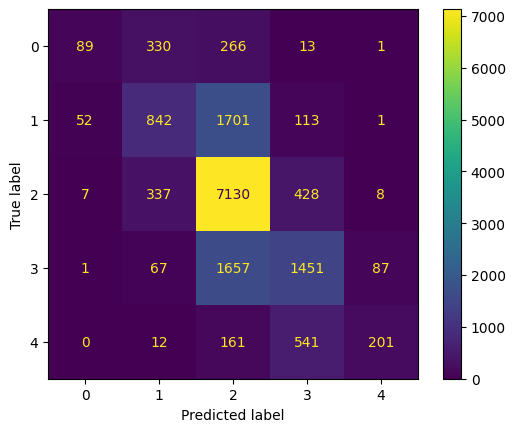

In [32]:
lr = Pipeline([('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(random_state=42, solver='liblinear')),
               ])

lr.fit(X_train, Y_train)
test_predict = lr.predict(X_test)

train_accuracy = round(lr.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Logistic Regression Train Accuracy Score : {}% ".format(train_accuracy))
print("Logistic Regression Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

# BERT

## Pretrained BERT 

In [33]:
# Name of the BERT model to use
model_name = 'bert-base-cased'

# Max length of tokens
length = len(df.Phrase)
dff = [len(i.split(" ")) for i in df.Phrase[:length]]
max_length = max(dff)+3

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

In [34]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

## Tokenizer

In [35]:
y_senti = to_categorical(df[df.data_type=='train'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=df[df.data_type=='train'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

train = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
def map_func(input_ids, masks, labels):
    # convert three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

train = train.map(map_func)
batch_size = 32

# shuffle and batch - dropping any remaining samples that don't cleanly
train = train.shuffle(100).batch(batch_size, drop_remainder=True)

train.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 51), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(32, 51), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))>

In [36]:
y_senti = to_categorical(df[df.data_type=='val'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=df[df.data_type=='val'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

val = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
val = val.map(map_func)
val = val.shuffle(100).batch(batch_size, drop_remainder=True)

## Transfer Learning -> Building model
### BERT base case

In [37]:
# Build model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert = TFAutoModel.from_pretrained('bert-base-cased')
embeddings = bert.bert(inputs)[1]

# convert bert embeddings into 5 output classes
output = Flatten()(embeddings)
output = Dense(256, activation='relu')(output)
output = Dense(128, activation='relu')(output)

output = Dense(5, activation='softmax', name='outputs')(output)

model = Model(inputs=inputs, outputs=output)

# Take a look at the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 51)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 51)]                 0         []                            
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['attention_mask[0][0]',      
                             ngAndCrossAttentions(last_   72         'input_ids[0][0]']           
                             hidden_state=(None, 51, 76                                       

In [38]:
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-6)
loss = CategoricalCrossentropy()
acc = CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

## Bert Training from Train and Validation Data

In [39]:
# Fit the model
history = model.fit(
    train,
    validation_data=val,
    epochs=10)

Epoch 1/10
3527/3527 [==============================] - 749s 209ms/step - loss: 0.8386 - accuracy: 0.6490 - val_loss: 0.7390 - val_accuracy: 0.6942
Epoch 2/10
3527/3527 [==============================] - 735s 208ms/step - loss: 0.7020 - accuracy: 0.7021 - val_loss: 0.7190 - val_accuracy: 0.7020
Epoch 3/10
3527/3527 [==============================] - 735s 208ms/step - loss: 0.6344 - accuracy: 0.7320 - val_loss: 0.7321 - val_accuracy: 0.6980
Epoch 4/10
3527/3527 [==============================] - 735s 208ms/step - loss: 0.5763 - accuracy: 0.7577 - val_loss: 0.7629 - val_accuracy: 0.6916
Epoch 5/10
3527/3527 [==============================] - 734s 208ms/step - loss: 0.5218 - accuracy: 0.7817 - val_loss: 0.8299 - val_accuracy: 0.6760
Epoch 6/10
3527/3527 [==============================] - 736s 209ms/step - loss: 0.4909 - accuracy: 0.7971 - val_loss: 0.8463 - val_accuracy: 0.6779
Epoch 7/10
3527/3527 [==============================] - 734s 208ms/step - loss: 0.4473 - accuracy: 0.8156 - val_

### Save/Load weights

In [40]:
model.save_weights('./sentiment-analysis-on-movie-reviews/bert_weights.h5')

In [41]:
model.load_weights('./sentiment-analysis-on-movie-reviews/bert_weights.h5')

## Confusion Matrix
### Test Data 

In [42]:
def map_func(input_ids, masks):
    return {'input_ids': input_ids, 'attention_mask': masks}

# Tokenize the input 
x = tokenizer(
    text=df[df.data_type=='test'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

test = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask']))
test = test.map(map_func)
test = test.batch(32)

In [43]:
y_test = df[df.data_type=='test'].Sentiment
y_pred = model.predict(test).argmax(axis=-1)

485/485 [==============================] - 40s 77ms/step


BERT Train Accuracy Score :      88% 
BERT Validation Accuracy Score : 66% 
BERT Test Accuracy Score  :      65% 



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

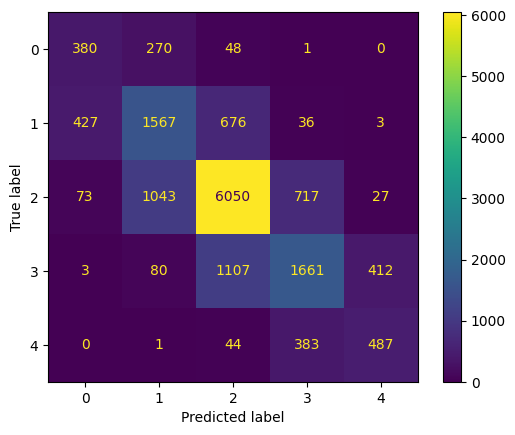

In [44]:
print("BERT Train Accuracy Score :      {:.0f}% ".format(history.history['accuracy'][-1]*100))
print("BERT Validation Accuracy Score : {:.0f}% ".format(history.history['val_accuracy'][-1]*100))
print("BERT Test Accuracy Score  :      {:.0f}% ".format(accuracy_score(y_test, y_pred)*100))
print()

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

## Classification Report
### Validation Data

In [45]:
print(classification_report(y_test, y_pred, target_names=target_categories))

              precision    recall  f1-score   support

           0       0.43      0.54      0.48       699
           1       0.53      0.58      0.55      2709
           2       0.76      0.76      0.76      7910
           3       0.59      0.51      0.55      3263
           4       0.52      0.53      0.53       915

    accuracy                           0.65     15496
   macro avg       0.57      0.59      0.57     15496
weighted avg       0.66      0.65      0.65     15496



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp